In [ ]:
## 9/12/17: this notebook subsets the relevant stuff from tf_sketchy.ipynb
## in order to compare triplet features to imagenet-only vgg 
## on the image retrieval task

In [9]:
from __future__ import division

import numpy as np
from numpy import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import linear_model

import os

import PIL
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

from skimage import data, io, filters

import pandas as pd

In [3]:
# load in features for photos
path_to_features = 'sketchy/triplet_features'
photo_features = np.load(os.path.join(path_to_features,'photo_features.npy'))
F = photo_features

# read in filenames and generate pandas dataframe with object labels
_filenames = pd.read_csv(os.path.join(path_to_features,'photo_filenames.txt'),header=None,names=['filename'])

filenames = []
for i in range(len(_filenames)):
    filenames.append(_filenames[_filenames.index==i].values[0][0])
filenames = ['sketchy' + f[1:] for f in filenames]
path = filenames
obj = [f.split('/')[3] for f in filenames]
img = [f.split('/')[4] for f in filenames]

data = {'path': path,
         'object': obj,
         'filename': img}
X = pd.DataFrame.from_dict(data)

# subset airplane features only
matches = X['object']=='airplane'
inds = np.where(matches==True)
X0 = X[matches]
F0 = F[inds]

In [4]:
# construct (11094,1024) version of photo feature matrix, called PF, that matches indexing of the sketch feature matrix
sketch_features = np.load('sketchy/airplane_features/airplane_sketch_features.npy')
_sketch_filenames = pd.read_csv('sketchy/airplane_features/airplane_sketch_filenames.txt',header=None,names=['filename'])
sketch_filenames = []
for i in range(len(_sketch_filenames)):
    sketch_filenames.append(_sketch_filenames[_sketch_filenames.index==i].values[0][0])
PF = []
inds = [] 
for sf in sketch_filenames:
    q = sf.split('/')[2]+'.jpg'
    PF.append(F0[X0['filename']==q])
    inds.append(np.where(X0['filename']==q)[0][0])
PF = np.squeeze(np.array(PF))
SF = sketch_features
inds = np.array(inds)

## zip together/concatenate the photo and sketch features
_F = np.hstack((PF,SF))

In [7]:
## get just complete sketches from each sketch folder
sketch_folders = np.unique([os.path.dirname(s) for s in sketch_filenames])
complete_paths = []
SF_complete = []
photos_complete = []
for (j,s) in enumerate(sketch_folders):
    complete_sketch = str(max([int(i.split('.')[0]) for i \
                               in os.listdir(s)])) + '.png'
    complete_paths.append(os.path.join(os.path.dirname(s),complete_sketch))
    SF_complete.append(SF[j])
    photos_complete.append(os.path.dirname(s).split('/')[-1])
SF_complete = np.array(SF_complete) 
photos_complete = np.array(photos_complete)

In [10]:
## get image classification within airplane class
run_this = 1
FEAT = SF_complete
LABELS = photos_complete
if run_this:
    # split sketch feature data for linear classification
    X_train, X_test, y_train, y_test = train_test_split(
        FEAT, LABELS, test_size=0.2, random_state=0)

    # check dimensionality of split data
    print 'dimensionality of train/test split'
    print X_train.shape, y_train.shape
    print X_test.shape, y_test.shape
    print ' '
    cval = True
    if cval==False:
        # compute linear classification accuracy (takes a minute or so to run)
        clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
        clf.score(X_test, y_test)   
    else:
        # compute linear classification accuracy (takes several minutes to run)       
#         clf = svm.SVC(kernel='linear', C=1)
        clf = linear_model.LogisticRegression(penalty='l2')
        scores = cross_val_score(clf, FEAT, LABELS, cv=2)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        ## SVM Accuracy: 0.41 (+/- 0.08) with cv=5 measured on 6/26/17 on intermediate sketches
        ## softmax Accuracy: 0.43 (+/- 0.01) with cv=2 measured on 9/11/17        

dimensionality of train/test split
(536, 1024) (536,)
(135, 1024) (135,)
 
Accuracy: 0.43 (+/- 0.01)


#### euclidean distances among sketches


In [12]:
from sklearn.metrics.pairwise import pairwise_distances

euc = pairwise_distances(SF_complete,metric='euclidean')
print euc.shape

(671, 671)


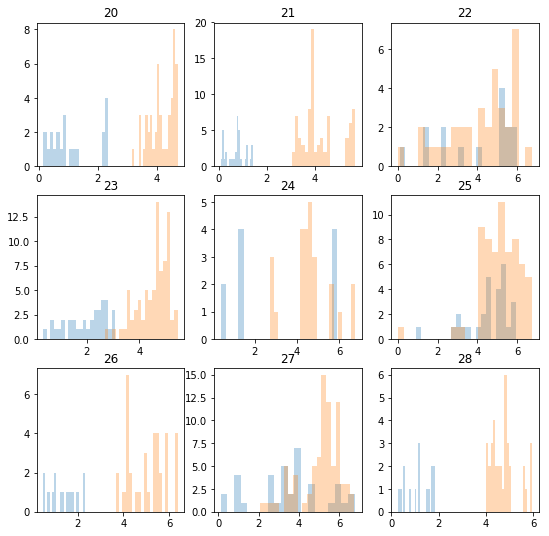

In [13]:
p_ind = 4
fp = 20
fig = plt.figure(figsize=(9,9))
for (_i,p_ind) in enumerate(np.arange(fp,fp+9)):
    unique_photos = np.unique(photos_complete)
    inds = np.where(photos_complete==unique_photos[p_ind])[0]
    start = inds[0]
    stop = inds[-1]

    # get within-photo sketch distances
    within_block = euc[start:stop+1,start:stop+1]
    assert len(within_block[np.triu_indices(len(within_block),k=1)])==(len(within_block)**2-len(within_block))/2
    within_distances = within_block[np.triu_indices(len(within_block),k=1)]

    # get between-photo sketch distances
    all_inds = np.arange(len(photos_complete))
    non_matches = [i for i in all_inds if i not in inds]
    _non_matches_shuff = np.random.RandomState(seed=0).permutation(non_matches)
    non_matches_shuff = _non_matches_shuff[:len(inds)]
    btw_distances = euc[start:stop+1,non_matches_shuff].flatten()

    # plot    
    plt.subplot(3,3,_i+1)
    h = plt.hist(within_distances,bins=20,alpha=0.3)
    h = plt.hist(btw_distances,bins=20,alpha=0.3)
    plt.title(str(p_ind))
plt.show()
    